## 1. Environment Setup and Configuration

In [12]:
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.special import logit, expit

from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error

# --- Configuration ---
EMBEDDINGS_DIR = "embs"
KMEANS_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, "kMeans_embeddings.csv")
MEAN_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, "mean_embeddings.csv")
SAMPLED_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, "samples_embeddings.csv")

# Set to True to use K-Means centroids for modeling, False to use random samples.
USE_KMEANS_DATA = False

## 2. Data Loading and Preprocessing

In [13]:
# Scientific Rationale: Load pre-computed representative and mean embeddings.
# The embeddings stored as strings in the CSV files are parsed back into NumPy arrays for numerical analysis.

def parse_embedding_string(embedding_str: str) -> np.ndarray:
    """Converts a string representation of a NumPy array back into an array."""
    # Remove brackets, strip whitespace, and split based on one or more spaces
    cleaned_str = embedding_str.strip('[]').strip()
    numbers = re.split(r'\s+', cleaned_str)
    return np.array([float(n) for n in numbers])

# Load mean embeddings for visualization
df_mean = pl.read_csv(MEAN_EMBEDDINGS_PATH).with_columns(
    pl.col('mean_embedding').map_elements(parse_embedding_string, return_dtype=pl.Object)
)

print(f"Loaded {len(df_mean)} mean embeddings.")

# Load representative embeddings for modeling
if USE_KMEANS_DATA:
    print(f"Loading K-Means representative embeddings from {KMEANS_EMBEDDINGS_PATH}")
    df_representatives = pl.read_csv(KMEANS_EMBEDDINGS_PATH).with_columns(
        pl.col('embedding').map_elements(parse_embedding_string, return_dtype=pl.Object)
    )
else:
    print(f"Loading randomly sampled representative embeddings from {SAMPLED_EMBEDDINGS_PATH}")
    df_representatives = pl.read_csv(SAMPLED_EMBEDDINGS_PATH).with_columns(
        pl.col('embedding').map_elements(parse_embedding_string, return_dtype=pl.Object)
    )

print(f"Loaded {len(df_representatives)} representative embeddings for modeling.")

Loaded 32 mean embeddings.
Loading randomly sampled representative embeddings from embs/samples_embeddings.csv
Loaded 640 representative embeddings for modeling.


## 3. Exploratory Data Analysis (EDA)

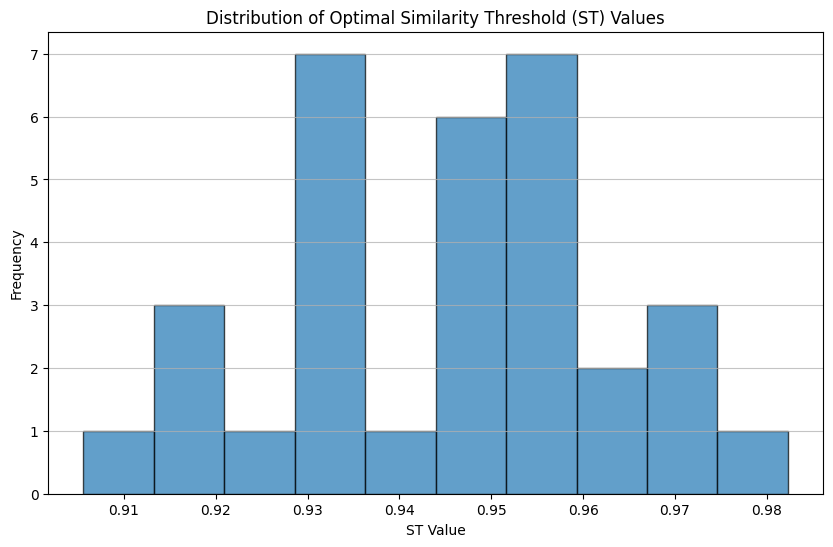

In [14]:
# Scientific Rationale: Visualize the distribution of ST values to understand their range and central tendency.
# This helps to confirm the data is within the expected bounds for a similarity threshold.
st_values = df_mean['st'].to_numpy()

plt.figure(figsize=(10, 6))
plt.hist(st_values, bins=10, alpha=0.7, edgecolor='black')
plt.title('Distribution of Optimal Similarity Threshold (ST) Values')
plt.xlabel('ST Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Total variance explained by PC1 & PC2: 23.87%


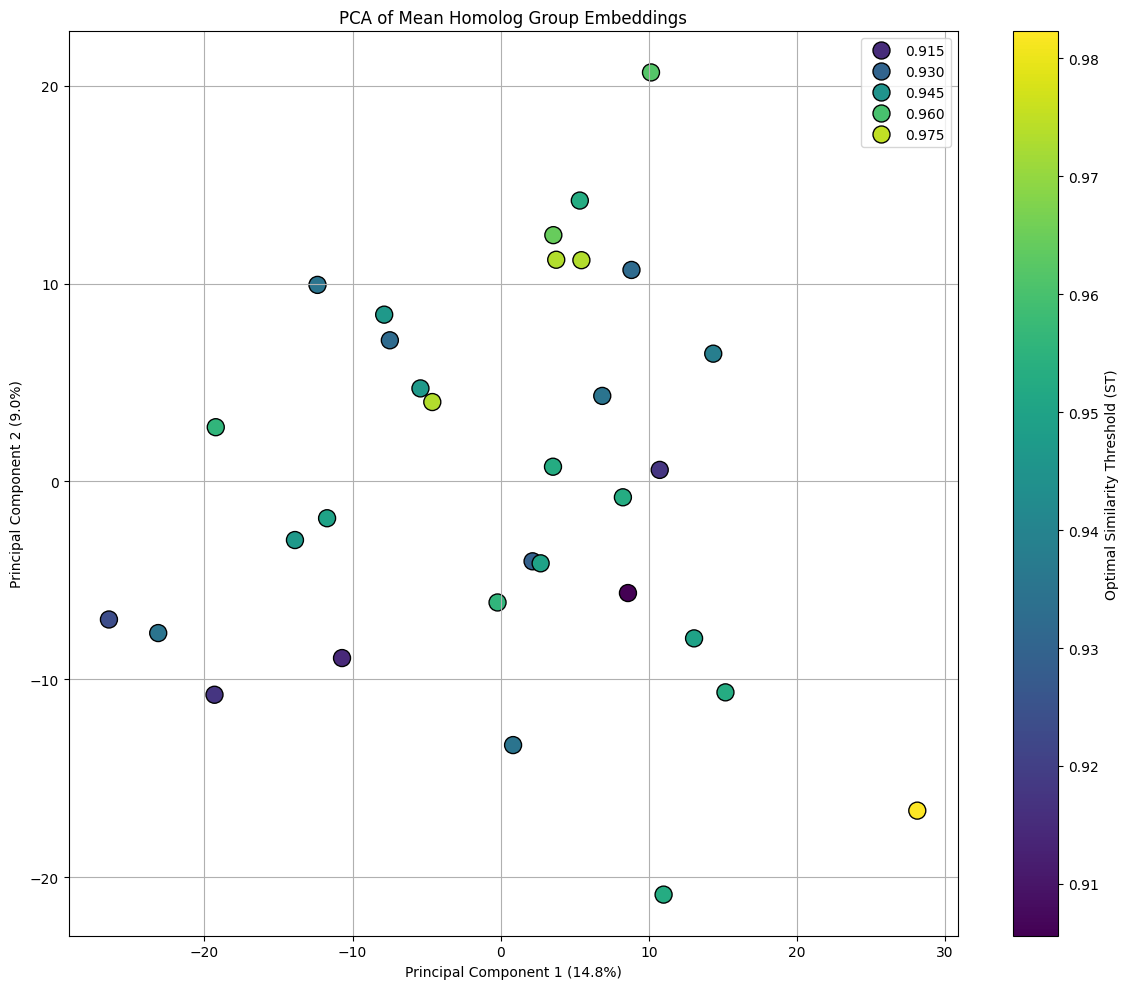

In [15]:
# Scientific Rationale: Use Principal Component Analysis (PCA) to visualize the high-dimensional embedding space.
# This allows for a qualitative assessment of whether homolog groups form distinct clusters and if the ST value correlates with position in the PCA space.

X_mean = np.vstack(df_mean['mean_embedding'].to_numpy())
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_mean)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_normalized)

explained_variance = pca.explained_variance_ratio_
print(f"Total variance explained by PC1 & PC2: {np.sum(explained_variance):.2%}")

plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_mean['st'].to_numpy(),
    palette='viridis',
    s=150,
    edgecolor='black'
)

plt.title('PCA of Mean Homolog Group Embeddings')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1%})')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1%})')
plt.grid(True)

norm = plt.Normalize(df_mean['st'].min(), df_mean['st'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
cbar = plt.colorbar(sm, ax=scatter.axes)
cbar.set_label('Optimal Similarity Threshold (ST)')

plt.tight_layout()
plt.show()

## 4. Model Training and Evaluation

In [16]:
# Scientific Rationale: Train a Gaussian Process (GP) Regressor to predict ST values from embeddings.
# ST values, which are probabilities, are logit-transformed to map them to an unbounded space, which is more suitable for GP regression.
# This transformation helps stabilize the model and improve performance.

X = np.vstack(df_representatives['embedding'].to_numpy())
y = df_representatives['st'].to_numpy()

# The logit transform requires values to be strictly between 0 and 1.
epsilon = 1e-7
y_clipped = np.clip(y, epsilon, 1 - epsilon)
y_transformed = logit(y_clipped)

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

# The RBF kernel models smooth functions, while the WhiteKernel accounts for noise.
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

print("Training Gaussian Process model...")
gp_model.fit(X_train, y_train)
print("Model training complete.")

# Evaluate on the test set, inverting the logit transform to get the original scale.
y_pred_transformed = gp_model.predict(X_test)
y_pred = expit(y_pred_transformed)
y_test_original = expit(y_test)

mse = mean_squared_error(y_test_original, y_pred)
print(f"\nMean Squared Error on test set: {mse:.6f}")

Training Gaussian Process model...
Model training complete.

Mean Squared Error on test set: 0.000004


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


## 5. Rigorous Model Validation with Leave-One-Group-Out (LOGO) Cross-Validation

In [17]:
# Scientific Rationale: LOGO-CV provides a robust estimate of the model's ability to generalize to unseen homolog groups.
# By training on all but one group and testing on the held-out group, we simulate real-world performance on novel protein families.

groups = df_representatives['homolog_group'].to_numpy()
logo = LeaveOneGroupOut()
results = []

print("Starting Leave-One-Group-Out Cross-Validation...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y_transformed, groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_transformed[train_idx], y_transformed[test_idx]
    held_out_group = groups[test_idx][0]

    # Define and train the GP model for this fold
    kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
    gp_model_cv = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp_model_cv.fit(X_train, y_train)
    y_pred_transformed, std_dev = gp_model_cv.predict(X_test, return_std=True)

    y_pred_original = expit(y_pred_transformed)
    y_test_original = expit(y_test)
    
    fold_mse = mean_squared_error(y_test_original, y_pred_original)
    
    for i in range(len(y_test_original)):
        results.append({
            'held_out_group': held_out_group,
            'true_st': y_test_original[i],
            'predicted_st': y_pred_original[i],
            'prediction_std': std_dev[i],
            'error_sq': (y_test_original[i] - y_pred_original[i])**2
        })
    print(f"  - Fold {fold+1}/{logo.get_n_splits(groups=groups)} | Tested on group: {held_out_group:<40} | MSE: {fold_mse:.6f}")

results_df = pl.DataFrame(results)
average_mse = results_df.select(pl.mean('error_sq')).item()
print(f"\nLOGO-CV Complete. Average MSE across all folds: {average_mse:.6f}")

Starting Leave-One-Group-Out Cross-Validation...


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 1/32 | Tested on group: 1-4-dihydroxy-2-naphthoate_octaprenyltransferase | MSE: 0.000459


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 2/32 | Tested on group: 2-amino-4-hydroxy-6-hydroxymethyldihydropteridine | MSE: 0.000813


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 3/32 | Tested on group: 2-oxoglutarate_dehydrogenase_E1          | MSE: 0.000015


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 4/32 | Tested on group: 2-succinyl-5-enolpyruvyl-6-hydroxy-3-cyclohexene-1-carboxylic-acid_synthase | MSE: 0.001280


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 5/32 | Tested on group: 3-methyl-2-oxobutanoate_hydroxymethyltransferase | MSE: 0.000060


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 6/32 | Tested on group: 4-diphosphocytidyl-2-C-methyl-D-erythritol_kinase | MSE: 0.000134


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 7/32 | Tested on group: 4-hydroxy-3-methylbut-2-en-1-yl_diphosphate_synthase | MSE: 0.000094


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 8/32 | Tested on group: 4-hydroxy-3-methylbut-2-enyl_diphosphate_reductase | MSE: 0.000128


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 9/32 | Tested on group: 4-hydroxy-tetrahydrodipicolinate_reductase | MSE: 0.000082


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 10/32 | Tested on group: ATP--corrinoid_adenosyltransferase       | MSE: 0.000045


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 11/32 | Tested on group: ATP_cob(I)alamin_adenosyltransferase     | MSE: 0.000373


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 12/32 | Tested on group: Amidophosphoribosyltransferase           | MSE: 0.002476


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 13/32 | Tested on group: DNA-directed_RNA_polymerase_subunit_beta | MSE: 0.000698


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 14/32 | Tested on group: Nicotinate-nucleotide_pyrophosphorylase  | MSE: 0.000028


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 15/32 | Tested on group: Phosphoserine_aminotransferase           | MSE: 0.002002


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 16/32 | Tested on group: RNA_methyltransferase                    | MSE: 0.000250


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 17/32 | Tested on group: Ribonuclease_PH                          | MSE: 0.000456


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 18/32 | Tested on group: Ribosomal_RNA_small_subunit_methyltransferase_I | MSE: 0.000036


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 19/32 | Tested on group: Tetraacyldisaccharide_4-kinase           | MSE: 0.000224


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 20/32 | Tested on group: Thiazole_synthase                        | MSE: 0.000021


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 21/32 | Tested on group: Translation_initiation_factor            | MSE: 0.000037


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 22/32 | Tested on group: acetolactate_synthase_small_subunit      | MSE: 0.001770


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 23/32 | Tested on group: biotin_synthase                          | MSE: 0.000220


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 24/32 | Tested on group: ketol-acid_reductoisomerase              | MSE: 0.000540


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 25/32 | Tested on group: ligase                                   | MSE: 0.000417


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 26/32 | Tested on group: methyltransferase                        | MSE: 0.000105


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 27/32 | Tested on group: phosphoglycerate_mutase_2_3-bisphosphoglycerate-independent | MSE: 0.000631


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 28/32 | Tested on group: porphobilinogen_synthase                 | MSE: 0.000040


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 29/32 | Tested on group: queuine_tRNA-ribosyltransferase          | MSE: 0.000025


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 30/32 | Tested on group: succinyltransferase                      | MSE: 0.000016


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  - Fold 31/32 | Tested on group: tRNA_(5-methylaminomethyl-2-thiouridylate)-methyltransferase | MSE: 0.000113
  - Fold 32/32 | Tested on group: type_I_DNA_topoisomerase                 | MSE: 0.000089

LOGO-CV Complete. Average MSE across all folds: 0.000427


/home/nilar@win.dtu.dk/.local/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


## 6. Performance Visualization

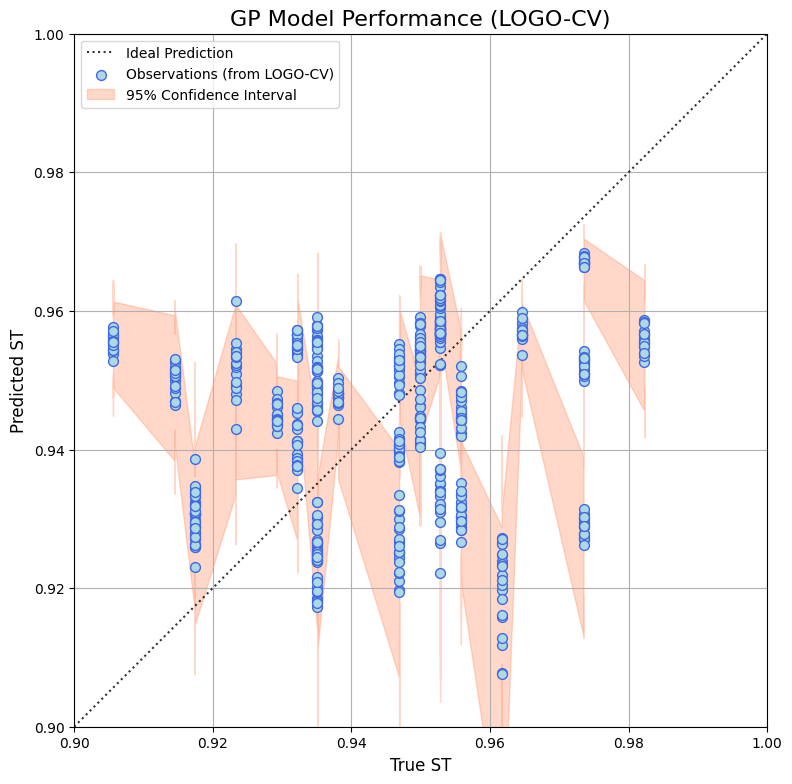

In [18]:
# Scientific Rationale: Plotting predicted vs. true values provides a visual confirmation of model performance.
# The 95% confidence interval, derived from the GP's predictive uncertainty, indicates the model's confidence in its predictions.
df_sorted = results_df.sort('true_st')

# Calculate the 95% Confidence Interval in the original [0, 1] scale.
predicted_st_clipped = np.clip(df_sorted['predicted_st'].to_numpy(), epsilon, 1 - epsilon)
predicted_st_transformed = logit(predicted_st_clipped)
std_dev_transformed = df_sorted['prediction_std'].to_numpy()

z_score = 1.96
upper_bound = expit(predicted_st_transformed + z_score * std_dev_transformed)
lower_bound = expit(predicted_st_transformed - z_score * std_dev_transformed)

# Create the plot
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot([0.9, 1], [0.9, 1], 'k:', alpha=0.8, label='Ideal Prediction') # Focus on the relevant range

ax.scatter(df_sorted['true_st'], df_sorted['predicted_st'], 
           edgecolor='royalblue', facecolor='lightblue', s=50, zorder=3, 
           label='Observations (from LOGO-CV)')

ax.fill_between(df_sorted['true_st'], lower_bound, upper_bound, 
                color='coral', alpha=0.3, label='95% Confidence Interval')

ax.set_xlabel('True ST', fontsize=12)
ax.set_ylabel('Predicted ST', fontsize=12)
ax.set_title('GP Model Performance (LOGO-CV)', fontsize=16)
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(0.9, 1)
ax.set_ylim(0.9, 1)
ax.set_aspect('equal', 'box')
plt.grid(True)
plt.show()

## 7. Baseline

In [ ]:
# Scientific Rationale: Train a Gaussian Process (GP) model using GPJax to predict ST values from embeddings.
# ST values (probabilities between 0 and 1) are logit-transformed to map them to an unbounded space (ℝ),
# which is the natural domain for a Gaussian Process, improving model stability and performance.

# --- Additional Imports ---
import gpjax as gpx
import optax as ox
import jax.random as jr
from jax import config
from jax_decision_making.posterior_handler import PosteriorHandler

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.key(42)

# --- Data Preparation ---
X = np.vstack(df_representatives['embedding'].to_numpy())
y = df_representatives['st'].to_numpy()

# The logit transform requires values to be strictly between 0 and 1.
epsilon = 1e-7
y_clipped = np.clip(y, epsilon, 1 - epsilon)
y_transformed = logit(y_clipped)

X_train, X_test, y_train_transformed, y_test_transformed = train_test_split(
    X, y_transformed, test_size=0.2, random_state=42
)

# Convert to GPJax Dataset
train_data = gpx.Dataset(X=X_train, y=y_train_transformed.reshape(-1, 1))

# --- GPJax Model Definition ---
# The Matern52 kernel is a good default for modeling smooth functions.
mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.Matern52(n_dims=X.shape[1])
prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)

# The likelihood builder handles the changing number of datapoints during training/CV
likelihood_builder = lambda n: gpx.likelihoods.Gaussian(num_datapoints=n)

# The PosteriorHandler simplifies the model fitting process.
posterior_handler = PosteriorHandler(
    prior,
    likelihood_builder=likelihood_builder,
    optimization_objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    optimizer=ox.adam(learning_rate=0.01),
    num_optimization_iters=200,
)

print("Training GPJax model...")
# Update the posterior with the training data to fit the model
posterior, history = posterior_handler.update_posterior(train_data, key=key)
print("Model training complete.")

# --- Evaluation ---
# Predict on the test set
latent_dist = posterior.predict(X_test, train_data=train_data)
predictive_dist = posterior.likelihood(latent_dist)
y_pred_transformed = predictive_dist.mean()

# Invert the logit transform to compare on the original [0, 1] scale.
y_pred = expit(y_pred_transformed)
y_test_original = expit(y_test_transformed)

mse = mean_squared_error(y_test_original, y_pred)
print(f"\nMean Squared Error on test set: {mse:.6f}")

In [ ]:
# Scientific Rationale: LOGO-CV provides a robust estimate of the model's ability to generalize to unseen homolog groups.
# By training on all but one group and testing on the held-out group, we simulate real-world performance on novel protein families.
# This approach uses GPJax within each fold of the cross-validation loop.

groups = df_representatives['homolog_group'].to_numpy()
logo = LeaveOneGroupOut()
results = []

print("Starting Leave-One-Group-Out Cross-Validation with GPJax...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y_transformed, groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_transformed[train_idx], y_transformed[test_idx]
    held_out_group = groups[test_idx][0]

    # Create dataset for the current fold
    train_data_cv = gpx.Dataset(X=X_train, y=y_train.reshape(-1, 1))

    # --- Define and train the GP model for this fold ---
    # Re-initialize the handler in each fold as the dataset size changes
    posterior_handler_cv = PosteriorHandler(
        prior,
        likelihood_builder=likelihood_builder,
        optimization_objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
        optimizer=ox.adam(learning_rate=0.01),
        num_optimization_iters=200,
    )

    # Get a new JAX key for each fold's optimization
    fold_key, key = jr.split(key)
    posterior_cv, _ = posterior_handler_cv.update_posterior(train_data_cv, key=fold_key)

    # --- Prediction for the held-out group ---
    latent_dist_cv = posterior_cv.predict(X_test, train_data=train_data_cv)
    predictive_dist_cv = posterior_cv.likelihood(latent_dist_cv)

    y_pred_transformed = predictive_dist_cv.mean()
    std_dev = predictive_dist_cv.stddev() # Standard deviation in the transformed space

    # Transform predictions and true values back to the original [0, 1] scale
    y_pred_original = expit(y_pred_transformed)
    y_test_original = expit(y_test)

    fold_mse = mean_squared_error(y_test_original, y_pred_original)

    # Store results for analysis
    for i in range(len(y_test_original)):
        results.append({
            'held_out_group': held_out_group,
            'true_st': y_test_original[i],
            'predicted_st': y_pred_original[i],
            'prediction_std': std_dev[i], # Note: this std is in the logit space
            'error_sq': (y_test_original[i] - y_pred_original[i])**2
        })
    print(f"  - Fold {fold+1}/{logo.get_n_splits(groups=groups)} | Tested on group: {held_out_group:<40} | MSE: {fold_mse:.6f}")

results_df = pl.DataFrame(results)
average_mse = results_df.select(pl.mean('error_sq')).item()
print(f"\nLOGO-CV Complete. Average MSE across all folds: {average_mse:.6f}")